<a href="https://colab.research.google.com/github/data-alch3m1st/PyTorch_tinkering/blob/main/skorch_CIFAR10_cv_v003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CIFAR-10 CNN (v003) ###

*Given the significant demands on memory (and I am using a MacBook so no CUDA for me), have to run this in Google Colab for baller T4 CUDA...*

In [11]:
# !pip install skorch
# !pip install torchmetrics

In [3]:
# Imports

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from skorch import NeuralNetClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix
    , accuracy_score, ConfusionMatrixDisplay
    )
from torchmetrics import Accuracy, ConfusionMatrix
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from timeit import default_timer as timer
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [4]:
# MacoOS device agnostic code:

if torch.cuda.is_available():
    device = "cuda"  # Use NVIDIA GPU (if available)
elif torch.backends.mps.is_available():
    device = "mps"  # Use Apple Silicon GPU (if available)
else:
    device = "cpu"  # Default to CPU if no GPU is available

device

'cuda'

In [5]:
# ---------------------------------------------------------
# 1. Prepare dataset (CIFAR-10) with Augmentations
# ---------------------------------------------------------

# Train transforms (with augmentations)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Flip images with 50% probability
    transforms.RandomCrop(32, padding=4),  # Add padding and crop randomly
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # CIFAR-10 stats
])

# Test transforms (only normalize)
test_transform = transforms.Compose([
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # CIFAR-10 stats
])

# CIFAR-10 dataset download
dataset = datasets.CIFAR10(
    './data', train=True, download=True
)

# Extract raw data and labels
X = torch.tensor(dataset.data).permute(0, 3, 1, 2).float() / 255.0  # Convert to [N, C, H, W]
y = torch.tensor(dataset.targets)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27, stratify=y
)

X_train.shape, X_test.shape, y_train.shape, y_test .shape

100%|██████████| 170M/170M [00:04<00:00, 42.5MB/s]


(torch.Size([40000, 3, 32, 32]),
 torch.Size([10000, 3, 32, 32]),
 torch.Size([40000]),
 torch.Size([10000]))

In [23]:
# ---------------------------------------------------------
# 2. Apply Transforms for Augmentation/Normalization
# ---------------------------------------------------------

# Define functions to apply transforms to batches (used in DataLoader)
train_transform_batch = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Flip images with 50% probability
    transforms.RandomCrop(32, padding=4),  # Add padding and crop randomly
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # CIFAR-10 stats
])

test_transform_batch = transforms.Compose([
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # CIFAR-10 stats
])


# Wrap in DataLoader for batching
train_loader = DataLoader(
    list(zip(X_train, y_train))
    , batch_size=128
    , shuffle=True
)

test_loader = DataLoader(
    list(zip(X_test, y_test))
    , batch_size=128
    , shuffle=False
)

In [ ]:
# # Split into training and testing sets
# X = torch.tensor(dataset.data).permute(0, 3, 1, 2).float() / 255.0

# # Normalize manually using CIFAR10 stats (aligning with transform above)
# mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
# std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3,1,1)
# X = (X - mean) / std
# y = torch.tensor(dataset.targets)

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2
#     , random_state=27
#     , stratify=y
# )

# X_train.shape, X_test.shape, y_train.shape, y_test .shape

(torch.Size([40000, 3, 32, 32]),
 torch.Size([10000, 3, 32, 32]),
 torch.Size([40000]),
 torch.Size([10000]))

In [ ]:
# # Wrap in DataLoader for batching
# train_loader = DataLoader(
#     list(zip(X_train, y_train))
#     , batch_size=128
#     , shuffle=True)

# test_loader = DataLoader(
#     list(zip(X_test, y_test))
#     , batch_size=128
#     , shuffle=False)

In [7]:
class Cifar10CNN_v3(nn.Module):
    def __init__(self, channels=64, dropout=0.3):
        super().__init__()
        # Convolutional block 1
        self.conv1 = nn.Conv2d(3, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)

        # Convolutional block 2
        self.conv2 = nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels * 2)

        # Convolutional block 3
        self.conv3 = nn.Conv2d(channels * 2, channels * 4, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(channels * 4)

        # Convolutional block 4
        self.conv4 = nn.Conv2d(channels * 4, channels * 8, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(channels * 8)

        # Global average pooling to reduce overfitting
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(channels * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_out = nn.Linear(256, 10)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)

        # Block 2
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)

        # Block 3
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)

        # Block 4
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)

        # Global average pooling
        x = self.global_avgpool(x)
        x = torch.flatten(x, 1)

        # Fully connected layers
        x = F.relu(self.fc1(self.dropout(x)))
        x = F.relu(self.fc2(self.dropout(x)))
        return self.fc_out(x)

In [8]:
%%time
# 3. Wrap (a base model) with skorch

net = NeuralNetClassifier(
    module=Cifar10CNN_v3
    , criterion=nn.CrossEntropyLoss
    , max_epochs=10
    , lr=0.001
    , optimizer=torch.optim.Adam
    , batch_size=128
    , iterator_train__shuffle=True
    , device=device
)

net.fit(X_train, y_train)

print("Train accuracy:", net.score(X_train, y_train))

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.4319       0.5665        1.1680  6.3274
      2        1.0310       0.6101        1.0921  4.4361
      3        0.8586       0.6896        0.9019  4.3235
      4        0.7432       0.6834        0.9196  4.3121
      5        0.6480       0.7366        0.7681  4.7448
      6        0.5736       0.6630        1.0648  5.4642
      7        0.5004       0.7034        0.8925  4.4379
      8        0.4360       0.7496        0.7705  4.3639
      9        0.3880       0.7250        0.8449  4.3640
     10        0.3388       0.7594        0.7670  4.4658
Train accuracy: 0.867925


In [9]:
# 4a. RandomizedSearchCV for Hyperparams Tuning

# (param_dist_v3)

param_dist = {
    "module__channels": [32, 64, 128],  # Increasing upper range
    "module__dropout": [0.2, 0.3, 0.5],  # Slightly reduced dropout values
    "lr": [1e-4, 3e-4, 1e-3],  # Removed extreme values for better control
    "optimizer": [torch.optim.Adam, torch.optim.SGD, torch.optim.RMSprop],
    "batch_size": [64, 128],  # Added smaller batch size for exploration
    "optimizer__momentum": [0.0, 0.9],
    "optimizer__weight_decay": [0.0, 1e-4, 5e-4],
}

In [10]:
%%time
# 4b. Randomized Search Actual (sample combos, actual run;)

rs = RandomizedSearchCV(
    estimator=net
    , param_distributions=param_dist
    , n_iter=10
    , cv=3
    , scoring="accuracy"
    , verbose=1
    , random_state=27
    , n_jobs=-1
)

rs.fit(X_train, y_train)

print("Best CV accuracy:", rs.best_score_)
print("Best params:", rs.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.6179       0.5169        1.3302  4.4919
      2        1.2178       0.5527        1.3477  4.5786
      3        1.0290       0.6485        1.0338  4.5365
      4        0.8977       0.6691        0.9354  4.4992
      5        0.7863       0.5731        1.2896  4.6003
      6        0.6965       0.7110        0.8468  4.4833
      7        0.6078       0.5804        1.3539  4.4872
      8        0.5242       0.7216        0.8172  4.5961
      9        0.4648       0.7131        0.9048  4.7459
     10        0.3946       0.7159        0.9234  4.6256
Best CV accuracy: 0.7008014783390434
Best params: {'optimizer__weight_decay': 0.0, 'optimizer__momentum': 0.9, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'module__dropout': 0.3, 'module__channels': 64, 'lr': 0.0003, 'batch_size': 128}


In [12]:
# 5. Send results to a dataframe for clean review;

results = pd.DataFrame(rs.cv_results_)
results[[
    "mean_test_score"
    , "std_test_score"
    , "params"
]].sort_values("mean_test_score", ascending=False, inplace=True)
results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer__weight_decay,param_optimizer__momentum,param_optimizer,param_module__dropout,param_module__channels,param_lr,param_batch_size,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,128.054189,6.681777,2.169934,0.467530,0.0001,0.0,<class 'torch.optim.rmsprop.RMSprop'>,0.5,128,0.0001,128,"{'optimizer__weight_decay': 0.0001, 'optimizer...",0.621044,0.665342,0.724593,0.670326,0.042420,3
1,59.212780,4.307163,1.367290,0.035737,0.0000,0.0,<class 'torch.optim.rmsprop.RMSprop'>,0.2,64,0.0001,128,"{'optimizer__weight_decay': 0.0, 'optimizer__m...",0.614894,0.654166,0.663917,0.644326,0.021188,4
2,40.729980,4.928447,1.125044,0.452975,0.0005,0.9,<class 'torch.optim.sgd.SGD'>,0.5,32,0.0001,64,"{'optimizer__weight_decay': 0.0005, 'optimizer...",0.323684,0.317858,0.297307,0.312950,0.011314,6


In [13]:
results['params'].iloc[0]

{'optimizer__weight_decay': 0.0001,
 'optimizer__momentum': 0.0,
 'optimizer': torch.optim.rmsprop.RMSprop,
 'module__dropout': 0.5,
 'module__channels': 128,
 'lr': 0.0001,
 'batch_size': 128}

In [14]:
# 6. Predict & Evaluate Performance with Best Model

best_model = rs.best_estimator_
y_pred = best_model.predict(X_test)

print("Accuracy:\n", accuracy_score(y_test, y_pred))
print('\n=================================================================\n')
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('\n=================================================================\n')
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = ConfusionMatrix(num_classes=10, task='multiclass')
cm_tensor = cm(torch.tensor(y_pred), y_test)

Accuracy:
 0.7181


Confusion Matrix:
 [[860   8  35  17  10  18   7  33   6   6]
 [ 40 871   1   6   2  11   4  13   9  43]
 [ 86   2 549  40  63 174  21  64   0   1]
 [ 29   1  19 320  30 514  20  63   3   1]
 [ 33   3  29  30 666 103  13 122   0   1]
 [  4   1   5  35  22 867   2  61   2   1]
 [  9   4  21  80  37  94 730  21   3   1]
 [  8   2  12   9  28  82   0 859   0   0]
 [136  27  12  34   4  40   5   9 722  11]
 [ 60  61   2  38   0  20   3  74   5 737]]


Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.86      0.76      1000
           1       0.89      0.87      0.88      1000
           2       0.80      0.55      0.65      1000
           3       0.53      0.32      0.40      1000
           4       0.77      0.67      0.72      1000
           5       0.45      0.87      0.59      1000
           6       0.91      0.73      0.81      1000
           7       0.65      0.86      0.74      1000
           8     

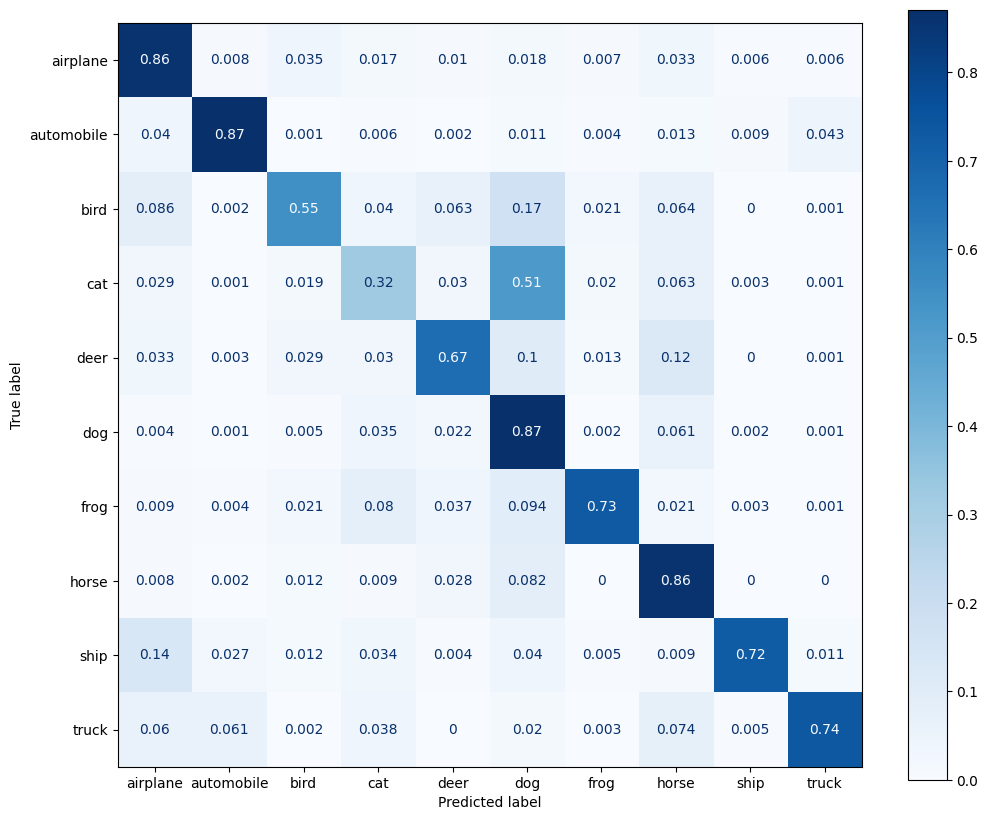

In [17]:
# 7. Plot the Confusion Matrix

fig, ax = plt.subplots(figsize=(12, 10))

# disp = ConfusionMatrixDisplay.from_predictions(
#     y_test, y_pred
#     , display_labels=dataset.classes
#     , cmap='Blues'
#     , normalize='true', xticks_rotation=45
# )

disp.plot(ax=ax, cmap='Blues')
plt.show();

In [24]:
 # 8. Functionize the train & test loop(s):

def train_step(model, loader, loss_fn, optimizer, accuracy_fn, device):
    model.train()
    total_loss, total_acc = 0, 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        # Apply train transforms to the batch
        X = train_transform_batch(X)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy_fn(y_pred.argmax(dim=1), y).item()
    return total_loss / len(loader), total_acc / len(loader)

def test_step(model, loader, loss_fn, accuracy_fn, device):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            # Apply test transforms to the batch
            X = test_transform_batch(X)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            total_loss += loss.item()
            total_acc += accuracy_fn(y_pred.argmax(dim=1), y).item()
    return total_loss / len(loader), total_acc / len(loader)

In [19]:
# ---------------------------------------------------------
# 9. Set the final model with the best params (including channels & dropout)
# ---------------------------------------------------------

model = Cifar10CNN_v3(
    channels=rs.best_params_["module__channels"]
    , dropout=rs.best_params_["module__dropout"]
).to(device)

model

Cifar10CNN_v3(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avgpool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc_out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [25]:
%%time

# 10. Train the Best Model

epochs = 50  # Increased to 50
optimizer = rs.best_params_["optimizer"](model.parameters(), lr=rs.best_params_["lr"])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = Accuracy(task='multiclass', num_classes=10).to(device)


for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(
        model, train_loader, loss_fn, optimizer, accuracy_fn, device)
    test_loss, test_acc = test_step(
        model, test_loader, loss_fn, accuracy_fn, device)
    scheduler.step()  # Update learning rate
    print(
        f"Epoch {epoch+1}/{epochs} - "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f} - "
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}"
    )

  2%|▏         | 1/50 [00:05<04:47,  5.87s/it]

Epoch 1/50 - Train Loss: 1.5019, Train Acc: 0.44 - Test Loss: 1.4721, Test Acc: 0.49


  4%|▍         | 2/50 [00:11<04:30,  5.63s/it]

Epoch 2/50 - Train Loss: 1.1391, Train Acc: 0.59 - Test Loss: 1.3059, Test Acc: 0.54


  6%|▌         | 3/50 [00:16<04:23,  5.60s/it]

Epoch 3/50 - Train Loss: 0.9958, Train Acc: 0.64 - Test Loss: 1.1886, Test Acc: 0.59


  8%|▊         | 4/50 [00:22<04:14,  5.52s/it]

Epoch 4/50 - Train Loss: 0.9028, Train Acc: 0.68 - Test Loss: 1.1721, Test Acc: 0.60


 10%|█         | 5/50 [00:27<04:08,  5.52s/it]

Epoch 5/50 - Train Loss: 0.8408, Train Acc: 0.70 - Test Loss: 1.5621, Test Acc: 0.55


 12%|█▏        | 6/50 [00:33<04:05,  5.59s/it]

Epoch 6/50 - Train Loss: 0.7904, Train Acc: 0.72 - Test Loss: 0.8965, Test Acc: 0.69


 14%|█▍        | 7/50 [00:39<04:00,  5.58s/it]

Epoch 7/50 - Train Loss: 0.7475, Train Acc: 0.74 - Test Loss: 0.7835, Test Acc: 0.73


 16%|█▌        | 8/50 [00:45<03:59,  5.71s/it]

Epoch 8/50 - Train Loss: 0.7078, Train Acc: 0.75 - Test Loss: 0.9950, Test Acc: 0.67


 18%|█▊        | 9/50 [00:50<03:53,  5.69s/it]

Epoch 9/50 - Train Loss: 0.6829, Train Acc: 0.76 - Test Loss: 0.9778, Test Acc: 0.69


 20%|██        | 10/50 [00:56<03:45,  5.63s/it]

Epoch 10/50 - Train Loss: 0.6577, Train Acc: 0.77 - Test Loss: 0.7065, Test Acc: 0.76


 22%|██▏       | 11/50 [01:01<03:39,  5.62s/it]

Epoch 11/50 - Train Loss: 0.6316, Train Acc: 0.78 - Test Loss: 0.8184, Test Acc: 0.73


 24%|██▍       | 12/50 [01:07<03:32,  5.59s/it]

Epoch 12/50 - Train Loss: 0.6060, Train Acc: 0.79 - Test Loss: 0.6767, Test Acc: 0.77


 26%|██▌       | 13/50 [01:12<03:26,  5.59s/it]

Epoch 13/50 - Train Loss: 0.5846, Train Acc: 0.80 - Test Loss: 0.6721, Test Acc: 0.77


 28%|██▊       | 14/50 [01:18<03:20,  5.58s/it]

Epoch 14/50 - Train Loss: 0.5687, Train Acc: 0.80 - Test Loss: 0.6304, Test Acc: 0.78


 30%|███       | 15/50 [01:24<03:15,  5.57s/it]

Epoch 15/50 - Train Loss: 0.5503, Train Acc: 0.81 - Test Loss: 0.7516, Test Acc: 0.75


 32%|███▏      | 16/50 [01:29<03:09,  5.59s/it]

Epoch 16/50 - Train Loss: 0.5343, Train Acc: 0.81 - Test Loss: 0.6049, Test Acc: 0.79


 34%|███▍      | 17/50 [01:35<03:04,  5.58s/it]

Epoch 17/50 - Train Loss: 0.5144, Train Acc: 0.82 - Test Loss: 0.7767, Test Acc: 0.75


 36%|███▌      | 18/50 [01:40<02:59,  5.60s/it]

Epoch 18/50 - Train Loss: 0.4971, Train Acc: 0.83 - Test Loss: 0.6862, Test Acc: 0.77


 38%|███▊      | 19/50 [01:46<02:53,  5.60s/it]

Epoch 19/50 - Train Loss: 0.4930, Train Acc: 0.83 - Test Loss: 0.5712, Test Acc: 0.81


 40%|████      | 20/50 [01:52<02:48,  5.60s/it]

Epoch 20/50 - Train Loss: 0.4732, Train Acc: 0.83 - Test Loss: 0.6271, Test Acc: 0.79


 42%|████▏     | 21/50 [01:57<02:41,  5.58s/it]

Epoch 21/50 - Train Loss: 0.4623, Train Acc: 0.84 - Test Loss: 0.5367, Test Acc: 0.82


 44%|████▍     | 22/50 [02:03<02:36,  5.60s/it]

Epoch 22/50 - Train Loss: 0.4464, Train Acc: 0.85 - Test Loss: 0.5485, Test Acc: 0.81


 46%|████▌     | 23/50 [02:08<02:31,  5.60s/it]

Epoch 23/50 - Train Loss: 0.4286, Train Acc: 0.85 - Test Loss: 0.6793, Test Acc: 0.78


 48%|████▊     | 24/50 [02:14<02:26,  5.63s/it]

Epoch 24/50 - Train Loss: 0.4237, Train Acc: 0.85 - Test Loss: 0.5257, Test Acc: 0.82


 50%|█████     | 25/50 [02:20<02:20,  5.63s/it]

Epoch 25/50 - Train Loss: 0.4142, Train Acc: 0.86 - Test Loss: 0.6622, Test Acc: 0.79


 52%|█████▏    | 26/50 [02:25<02:15,  5.65s/it]

Epoch 26/50 - Train Loss: 0.3980, Train Acc: 0.86 - Test Loss: 0.5197, Test Acc: 0.83


 54%|█████▍    | 27/50 [02:31<02:09,  5.64s/it]

Epoch 27/50 - Train Loss: 0.3971, Train Acc: 0.86 - Test Loss: 0.4719, Test Acc: 0.84


 56%|█████▌    | 28/50 [02:37<02:04,  5.65s/it]

Epoch 28/50 - Train Loss: 0.3801, Train Acc: 0.87 - Test Loss: 0.5536, Test Acc: 0.82


 58%|█████▊    | 29/50 [02:42<01:58,  5.64s/it]

Epoch 29/50 - Train Loss: 0.3737, Train Acc: 0.87 - Test Loss: 0.4704, Test Acc: 0.85


 60%|██████    | 30/50 [02:48<01:52,  5.64s/it]

Epoch 30/50 - Train Loss: 0.3616, Train Acc: 0.87 - Test Loss: 0.4907, Test Acc: 0.84


 62%|██████▏   | 31/50 [02:54<01:47,  5.64s/it]

Epoch 31/50 - Train Loss: 0.3559, Train Acc: 0.88 - Test Loss: 0.5346, Test Acc: 0.83


 64%|██████▍   | 32/50 [02:59<01:41,  5.63s/it]

Epoch 32/50 - Train Loss: 0.3446, Train Acc: 0.88 - Test Loss: 0.4658, Test Acc: 0.85


 66%|██████▌   | 33/50 [03:05<01:35,  5.64s/it]

Epoch 33/50 - Train Loss: 0.3382, Train Acc: 0.88 - Test Loss: 0.4566, Test Acc: 0.85


 68%|██████▊   | 34/50 [03:10<01:29,  5.62s/it]

Epoch 34/50 - Train Loss: 0.3311, Train Acc: 0.88 - Test Loss: 0.4431, Test Acc: 0.85


 70%|███████   | 35/50 [03:16<01:24,  5.63s/it]

Epoch 35/50 - Train Loss: 0.3170, Train Acc: 0.89 - Test Loss: 0.4341, Test Acc: 0.85


 72%|███████▏  | 36/50 [03:22<01:18,  5.61s/it]

Epoch 36/50 - Train Loss: 0.3130, Train Acc: 0.89 - Test Loss: 0.4385, Test Acc: 0.86


 74%|███████▍  | 37/50 [03:27<01:13,  5.63s/it]

Epoch 37/50 - Train Loss: 0.3064, Train Acc: 0.89 - Test Loss: 0.4270, Test Acc: 0.86


 76%|███████▌  | 38/50 [03:33<01:07,  5.62s/it]

Epoch 38/50 - Train Loss: 0.3011, Train Acc: 0.89 - Test Loss: 0.4360, Test Acc: 0.86


 78%|███████▊  | 39/50 [03:39<01:01,  5.63s/it]

Epoch 39/50 - Train Loss: 0.2991, Train Acc: 0.90 - Test Loss: 0.4206, Test Acc: 0.86


 80%|████████  | 40/50 [03:44<00:56,  5.62s/it]

Epoch 40/50 - Train Loss: 0.2926, Train Acc: 0.90 - Test Loss: 0.4324, Test Acc: 0.86


 82%|████████▏ | 41/50 [03:50<00:50,  5.64s/it]

Epoch 41/50 - Train Loss: 0.2928, Train Acc: 0.90 - Test Loss: 0.4335, Test Acc: 0.86


 84%|████████▍ | 42/50 [03:55<00:44,  5.62s/it]

Epoch 42/50 - Train Loss: 0.2845, Train Acc: 0.90 - Test Loss: 0.4280, Test Acc: 0.87


 86%|████████▌ | 43/50 [04:01<00:39,  5.64s/it]

Epoch 43/50 - Train Loss: 0.2816, Train Acc: 0.90 - Test Loss: 0.4392, Test Acc: 0.86


 88%|████████▊ | 44/50 [04:07<00:33,  5.65s/it]

Epoch 44/50 - Train Loss: 0.2767, Train Acc: 0.90 - Test Loss: 0.4223, Test Acc: 0.87


 90%|█████████ | 45/50 [04:12<00:28,  5.63s/it]

Epoch 45/50 - Train Loss: 0.2817, Train Acc: 0.90 - Test Loss: 0.4230, Test Acc: 0.86


 92%|█████████▏| 46/50 [04:19<00:23,  5.81s/it]

Epoch 46/50 - Train Loss: 0.2722, Train Acc: 0.90 - Test Loss: 0.4195, Test Acc: 0.87


 94%|█████████▍| 47/50 [04:24<00:17,  5.74s/it]

Epoch 47/50 - Train Loss: 0.2724, Train Acc: 0.90 - Test Loss: 0.4216, Test Acc: 0.87


 96%|█████████▌| 48/50 [04:30<00:11,  5.71s/it]

Epoch 48/50 - Train Loss: 0.2722, Train Acc: 0.91 - Test Loss: 0.4248, Test Acc: 0.87


 98%|█████████▊| 49/50 [04:35<00:05,  5.67s/it]

Epoch 49/50 - Train Loss: 0.2713, Train Acc: 0.90 - Test Loss: 0.4239, Test Acc: 0.87


100%|██████████| 50/50 [04:41<00:00,  5.63s/it]

Epoch 50/50 - Train Loss: 0.2735, Train Acc: 0.90 - Test Loss: 0.4229, Test Acc: 0.86
CPU times: user 4min 36s, sys: 975 ms, total: 4min 37s
Wall time: 4min 41s


In [29]:
# ---------------------------------------------------------
# 11. Eval Mode for Final Predictions, Metrics on Best Model
# ---------------------------------------------------------

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels
all_preds = []
all_labels = []

# Disable gradient computation for inference
with torch.inference_mode():
    # Iterate through the test DataLoader
    for images, labels in test_loader:
        # Apply transforms dynamically via the test DataLoader
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Get predicted class indices
        preds = outputs.argmax(dim=1)

        # Collect predictions and true labels
        all_preds.append(preds.cpu())  # Move to CPU for metric calculations
        all_labels.append(labels.cpu())

# Concatenate all predictions and labels into single tensors
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Evaluate metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("\nAccuracy:\n", accuracy_score(all_labels.numpy(), all_preds.numpy()))
print('\n=================================================================\n')
print('Confusion Matrix:\n', confusion_matrix(all_labels.numpy(), all_preds.numpy()))
print('\n=================================================================\n')
print("Classification Report:\n", classification_report(all_labels.numpy(), all_preds.numpy()))


Accuracy:
 0.2622


Confusion Matrix:
 [[ 62   0   0 346 122   4  11   0 455   0]
 [  2   1   0 553 254   8  17   0 165   0]
 [  3   0  15 660 184  14  21   0 103   0]
 [  0   0   1 958  20   3   3   0  15   0]
 [  0   0   0 447 504   3   0   0  46   0]
 [  0   0   0 795  54 139   1   0  11   0]
 [  0   0   0 697 138   8 145   0  12   0]
 [  0   0   0 435 436  73   1   1  54   0]
 [  1   0   0 175  24   0   6   0 794   0]
 [  0   0   1 607 116  74  15   0 184   3]]


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.06      0.12      1000
           1       1.00      0.00      0.00      1000
           2       0.88      0.01      0.03      1000
           3       0.17      0.96      0.29      1000
           4       0.27      0.50      0.35      1000
           5       0.43      0.14      0.21      1000
           6       0.66      0.14      0.24      1000
           7       1.00      0.00      0.00      1000
           8    

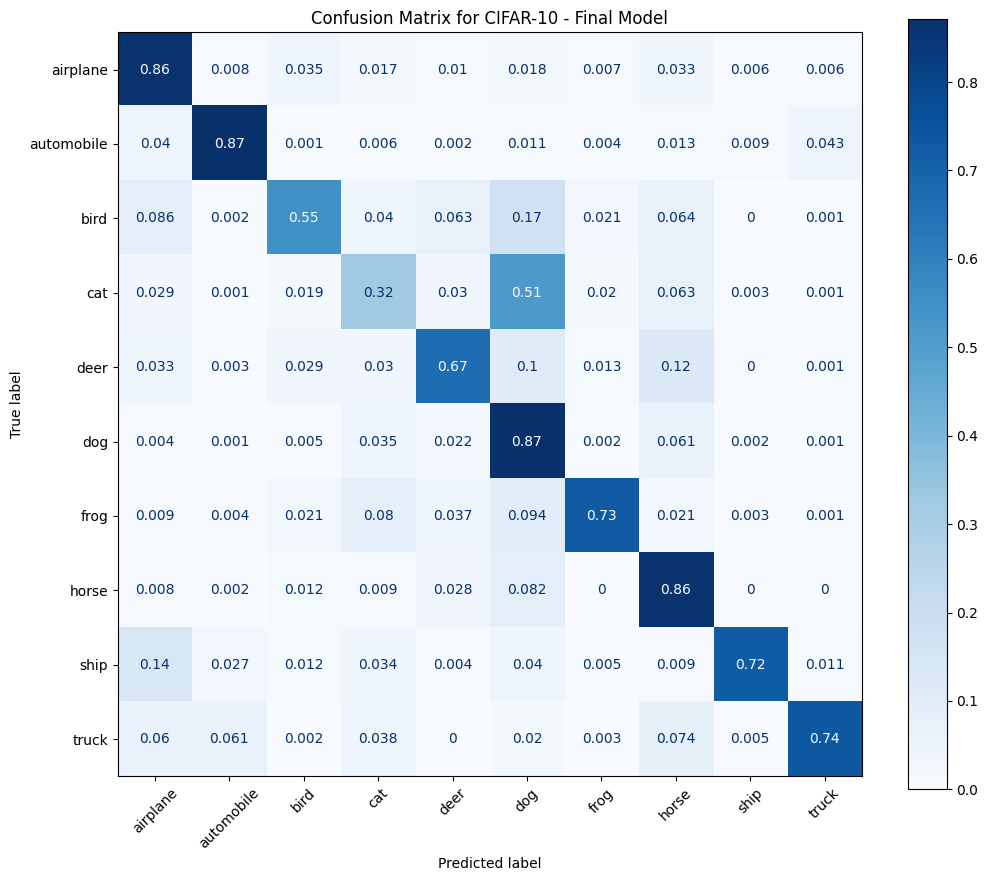

In [30]:
# ---------------------------------------------------------
# 12. Final Confusion Matrix for Best & Fully Trained Model
# ---------------------------------------------------------

fig, ax = plt.subplots(figsize=(12, 10))

# disp = ConfusionMatrixDisplay.from_predictions(
#     all_labels, all_preds
#     , display_labels=dataset.classes
#     , normalize='true'
# )

disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix for CIFAR-10 - Final Model")
plt.show();

In [31]:
# Retrain step?

# epochs = 30
# for epoch in tqdm(range(epochs)):
#     train_loss, train_acc = train_step(
#         model, train_loader, loss_fn, optimizer, accuracy_fn, device)
#     test_loss, test_acc = test_step(
#         model, test_loader, loss_fn, accuracy_fn, device)
#     print(
#         f"Epoch {epoch+1}/{epochs} - "
#         f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f} - "
#         f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}"
#     )


epochs = 30  # Increased to 50
optimizer = rs.best_params_["optimizer"](model.parameters(), lr=rs.best_params_["lr"])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = Accuracy(task='multiclass', num_classes=10).to(device)


for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(
        model, train_loader, loss_fn, optimizer, accuracy_fn, device)
    test_loss, test_acc = test_step(
        model, test_loader, loss_fn, accuracy_fn, device)
    scheduler.step()  # Update learning rate
    print(
        f"Epoch {epoch+1}/{epochs} - "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f} - "
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}"
    )

  3%|▎         | 1/30 [00:05<02:40,  5.54s/it]

Epoch 1/30 - Train Loss: 0.4941, Train Acc: 0.83 - Test Loss: 0.5384, Test Acc: 0.82


  7%|▋         | 2/30 [00:10<02:32,  5.43s/it]

Epoch 2/30 - Train Loss: 0.4226, Train Acc: 0.85 - Test Loss: 0.5485, Test Acc: 0.82


 10%|█         | 3/30 [00:16<02:27,  5.46s/it]

Epoch 3/30 - Train Loss: 0.4064, Train Acc: 0.86 - Test Loss: 1.0228, Test Acc: 0.72


 13%|█▎        | 4/30 [00:21<02:21,  5.44s/it]

Epoch 4/30 - Train Loss: 0.4023, Train Acc: 0.86 - Test Loss: 0.7434, Test Acc: 0.78


 17%|█▋        | 5/30 [00:27<02:15,  5.43s/it]

Epoch 5/30 - Train Loss: 0.3897, Train Acc: 0.86 - Test Loss: 0.5977, Test Acc: 0.81


 20%|██        | 6/30 [00:32<02:10,  5.45s/it]

Epoch 6/30 - Train Loss: 0.3798, Train Acc: 0.87 - Test Loss: 0.5522, Test Acc: 0.82


 23%|██▎       | 7/30 [00:38<02:05,  5.44s/it]

Epoch 7/30 - Train Loss: 0.3697, Train Acc: 0.87 - Test Loss: 0.7634, Test Acc: 0.77


 27%|██▋       | 8/30 [00:43<02:00,  5.46s/it]

Epoch 8/30 - Train Loss: 0.3599, Train Acc: 0.87 - Test Loss: 0.4910, Test Acc: 0.84


 30%|███       | 9/30 [00:49<01:54,  5.45s/it]

Epoch 9/30 - Train Loss: 0.3530, Train Acc: 0.88 - Test Loss: 0.4946, Test Acc: 0.84


 33%|███▎      | 10/30 [00:54<01:49,  5.48s/it]

Epoch 10/30 - Train Loss: 0.3343, Train Acc: 0.88 - Test Loss: 0.4954, Test Acc: 0.84


 37%|███▋      | 11/30 [01:00<01:43,  5.47s/it]

Epoch 11/30 - Train Loss: 0.3254, Train Acc: 0.89 - Test Loss: 0.5559, Test Acc: 0.83


 40%|████      | 12/30 [01:05<01:39,  5.50s/it]

Epoch 12/30 - Train Loss: 0.3145, Train Acc: 0.89 - Test Loss: 0.5771, Test Acc: 0.83


 43%|████▎     | 13/30 [01:11<01:33,  5.49s/it]

Epoch 13/30 - Train Loss: 0.3037, Train Acc: 0.89 - Test Loss: 0.4464, Test Acc: 0.86


 47%|████▋     | 14/30 [01:16<01:28,  5.52s/it]

Epoch 14/30 - Train Loss: 0.2941, Train Acc: 0.90 - Test Loss: 0.5160, Test Acc: 0.84


 50%|█████     | 15/30 [01:22<01:24,  5.61s/it]

Epoch 15/30 - Train Loss: 0.2820, Train Acc: 0.90 - Test Loss: 0.4335, Test Acc: 0.86


 53%|█████▎    | 16/30 [01:28<01:18,  5.59s/it]

Epoch 16/30 - Train Loss: 0.2763, Train Acc: 0.90 - Test Loss: 0.4887, Test Acc: 0.85


 57%|█████▋    | 17/30 [01:33<01:12,  5.58s/it]

Epoch 17/30 - Train Loss: 0.2597, Train Acc: 0.91 - Test Loss: 0.4233, Test Acc: 0.87


 60%|██████    | 18/30 [01:39<01:06,  5.55s/it]

Epoch 18/30 - Train Loss: 0.2548, Train Acc: 0.91 - Test Loss: 0.4362, Test Acc: 0.87


 63%|██████▎   | 19/30 [01:44<01:02,  5.64s/it]

Epoch 19/30 - Train Loss: 0.2444, Train Acc: 0.91 - Test Loss: 0.4463, Test Acc: 0.87


 67%|██████▋   | 20/30 [01:50<00:55,  5.60s/it]

Epoch 20/30 - Train Loss: 0.2322, Train Acc: 0.92 - Test Loss: 0.4571, Test Acc: 0.86


 70%|███████   | 21/30 [01:56<00:52,  5.79s/it]

Epoch 21/30 - Train Loss: 0.2259, Train Acc: 0.92 - Test Loss: 0.4192, Test Acc: 0.87


 73%|███████▎  | 22/30 [02:02<00:46,  5.78s/it]

Epoch 22/30 - Train Loss: 0.2180, Train Acc: 0.92 - Test Loss: 0.4086, Test Acc: 0.88


 77%|███████▋  | 23/30 [02:08<00:40,  5.73s/it]

Epoch 23/30 - Train Loss: 0.2099, Train Acc: 0.93 - Test Loss: 0.4101, Test Acc: 0.88


 80%|████████  | 24/30 [02:13<00:34,  5.67s/it]

Epoch 24/30 - Train Loss: 0.2058, Train Acc: 0.93 - Test Loss: 0.4059, Test Acc: 0.88


 83%|████████▎ | 25/30 [02:19<00:28,  5.67s/it]

Epoch 25/30 - Train Loss: 0.1959, Train Acc: 0.93 - Test Loss: 0.4045, Test Acc: 0.88


 87%|████████▋ | 26/30 [02:24<00:22,  5.63s/it]

Epoch 26/30 - Train Loss: 0.1953, Train Acc: 0.93 - Test Loss: 0.4089, Test Acc: 0.88


 90%|█████████ | 27/30 [02:30<00:16,  5.63s/it]

Epoch 27/30 - Train Loss: 0.1934, Train Acc: 0.93 - Test Loss: 0.3993, Test Acc: 0.88


 93%|█████████▎| 28/30 [02:35<00:11,  5.60s/it]

Epoch 28/30 - Train Loss: 0.1936, Train Acc: 0.93 - Test Loss: 0.4012, Test Acc: 0.88


 97%|█████████▋| 29/30 [02:41<00:05,  5.61s/it]

Epoch 29/30 - Train Loss: 0.1881, Train Acc: 0.93 - Test Loss: 0.3979, Test Acc: 0.88


100%|██████████| 30/30 [02:47<00:00,  5.57s/it]

Epoch 30/30 - Train Loss: 0.1860, Train Acc: 0.93 - Test Loss: 0.3953, Test Acc: 0.88


In [32]:
train_acc, test_acc

(0.9334315095846646, 0.8817246835443038)

In [36]:
from torchmetrics.classification import MulticlassConfusionMatrix, MulticlassAccuracy
# from torchmetrics.functional import precision_recall

# Number of classes in CIFAR-10
num_classes = 10

# Initialize confusion matrix and accuracy metric
confusion_matrix = MulticlassConfusionMatrix(num_classes=num_classes).to(device)
accuracy_metric = MulticlassAccuracy(num_classes=num_classes).to(device)

# Set model to evaluation mode
model.eval()

# Initialize predictions and labels
all_preds = []
all_labels = []

# Disable gradient computations for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        preds = outputs.argmax(dim=1)  # Predicted classes

        # Update metrics
        confusion_matrix.update(preds, labels)
        accuracy_metric.update(preds, labels)

        # Collect predictions and labels for debugging
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# Compute confusion matrix and accuracy
final_conf_matrix = confusion_matrix.compute().cpu()
final_accuracy = accuracy_metric.compute().item()

# Convert confusion matrix to percentages
conf_matrix_percent = final_conf_matrix / final_conf_matrix.sum(axis=1, keepdims=True)

# Print results
print("\nPyTorch-Native Accuracy:", final_accuracy)
print("\nConfusion Matrix (Counts):\n", final_conf_matrix)
print("\nConfusion Matrix (Percentages):\n", conf_matrix_percent)

# Per-class Precision and Recall
precision, recall = precision_recall(final_conf_matrix, average=None)
for i in range(num_classes):
    print(f"Class {i} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}")


PyTorch-Native Accuracy: 0.2352999895811081

Confusion Matrix (Counts):
 tensor([[ 55,   0,   1, 246,  55,   1,  21,   0, 621,   0],
        [  2,   4,   0, 546, 140,   9,  20,   0, 276,   3],
        [  4,   0,  21, 673,  82,   4,  26,   0, 190,   0],
        [  0,   0,   1, 958,  10,   0,   4,   0,  27,   0],
        [  1,   0,   0, 639, 292,   0,   0,   0,  68,   0],
        [  0,   0,   0, 893,  40,  46,   2,   0,  19,   0],
        [  0,   0,   0, 776,  67,   0, 140,   0,  17,   0],
        [  0,   0,   0, 504, 359,  28,   2,   6, 101,   0],
        [  1,   0,   0, 179,   6,   1,   3,   0, 810,   0],
        [  0,   0,   0, 575,  78,  25,  10,   0, 291,  21]])

Confusion Matrix (Percentages):
 tensor([[0.0550, 0.0000, 0.0010, 0.2460, 0.0550, 0.0010, 0.0210, 0.0000, 0.6210,
         0.0000],
        [0.0020, 0.0040, 0.0000, 0.5460, 0.1400, 0.0090, 0.0200, 0.0000, 0.2760,
         0.0030],
        [0.0040, 0.0000, 0.0210, 0.6730, 0.0820, 0.0040, 0.0260, 0.0000, 0.1900,
         0.0

NameError: name 'precision_recall' is not defined

In [38]:
print("Shape of all_preds:", all_preds.shape)
print("Shape of all_labels:", all_labels.shape)
print("Sample predictions:", all_preds[:10])
print("Sample labels:", all_labels[:10])

AttributeError: 'list' object has no attribute 'shape'

In [39]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

all_preds_np = all_preds.numpy()
all_labels_np = all_labels.numpy()

print("\nAccuracy (sklearn):", accuracy_score(all_labels_np, all_preds_np))
print("\nConfusion Matrix (sklearn):\n", confusion_matrix(all_labels_np, all_preds_np))
print("\nClassification Report (sklearn):\n", classification_report(all_labels_np, all_preds_np))

AttributeError: 'list' object has no attribute 'numpy'

In [35]:
# 11. Eval Mode for Final Predix, Metrics on Best & Fully Trained Model

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

print("\nAccuracy:\n", accuracy_score(all_labels, all_preds))
print('\n=================================================================\n')
print('Confusion Matrix:\n', confusion_matrix(all_labels, all_preds))
print('\n=================================================================\n')
print("Classification Report:\n", classification_report(all_labels, all_preds))


Accuracy:
 0.2353


Confusion Matrix:
 [[ 55   0   1 246  55   1  21   0 621   0]
 [  2   4   0 546 140   9  20   0 276   3]
 [  4   0  21 673  82   4  26   0 190   0]
 [  0   0   1 958  10   0   4   0  27   0]
 [  1   0   0 639 292   0   0   0  68   0]
 [  0   0   0 893  40  46   2   0  19   0]
 [  0   0   0 776  67   0 140   0  17   0]
 [  0   0   0 504 359  28   2   6 101   0]
 [  1   0   0 179   6   1   3   0 810   0]
 [  0   0   0 575  78  25  10   0 291  21]]


Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.06      0.10      1000
           1       1.00      0.00      0.01      1000
           2       0.91      0.02      0.04      1000
           3       0.16      0.96      0.27      1000
           4       0.26      0.29      0.27      1000
           5       0.40      0.05      0.08      1000
           6       0.61      0.14      0.23      1000
           7       1.00      0.01      0.01      1000
           8    

ValueError: unknown is not supported

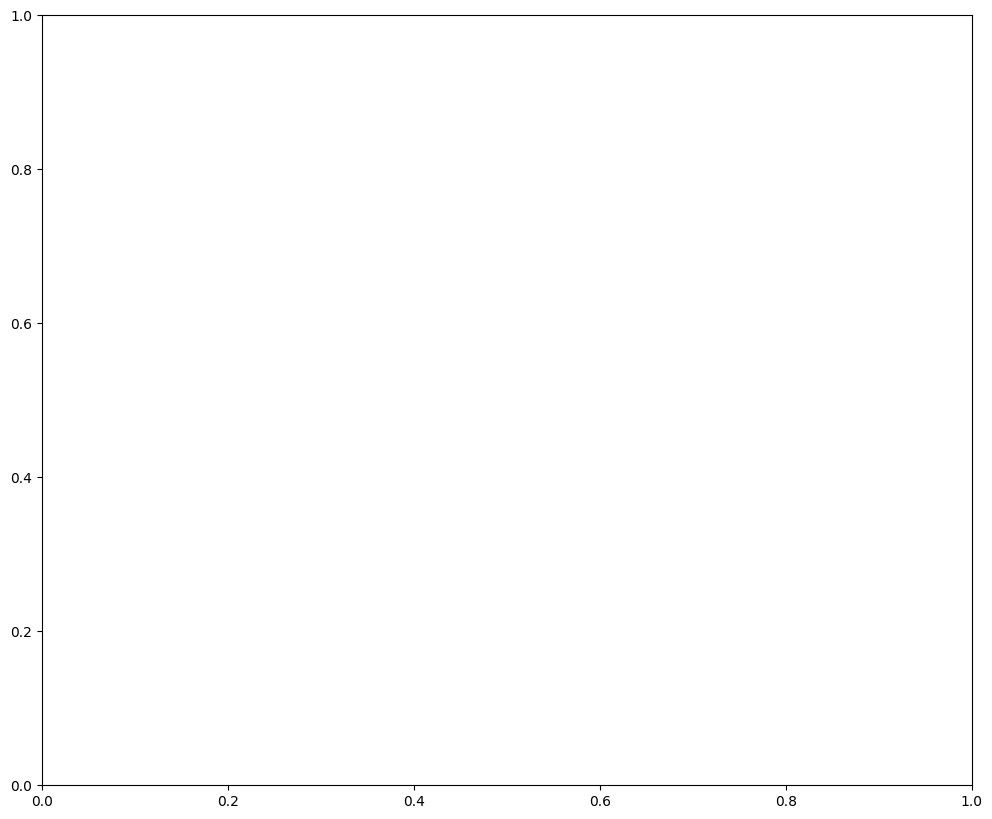

In [37]:
# 12. Final Confusion Matrix for Best & Fully Trained Model

fig, ax = plt.subplots(figsize=(12, 10))

disp = ConfusionMatrixDisplay.from_predictions(
    all_labels, all_preds
    , display_labels=dataset.classes
    , normalize='true'
)

disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix for CIFAR-10 - Final Model")
plt.show();